In [2]:
import torch
import torchvision
from datasets import load_dataset
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


In [5]:
# Cifar100 data import


# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # Normalize the images
])

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

# Download and load the training data
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from copy import deepcopy
from torch.utils.data import Subset

# Transform 
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.

    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,  
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,  
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5, 
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10, 
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17, 
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,  
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13, 
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19, 
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return coarse_labels[targets]

# Construct Coarse Dataset With the Function
superclasses = ['aquatic_mammals','fish','flowers','food_containers','fruit_and_vegetables','household_electrical_devices',
                'household_furniture','insects','large_carnivores','large_man-made_outdoor_things','large_natural_outdoor_scenes',
                'large_omnivores_and_herbivores','medium-sized_mammals','non-insect_invertebrates','people','reptiles','small_mammals',
                'trees','vehicles 1','vehicles 2']
trainset_coarse = deepcopy(trainset)
trainset_coarse.targets = sparse2coarse(trainset_coarse.targets)
trainset_coarse.classes = superclasses
trainset_coarse.class_to_idx = dict(zip(trainset_coarse.classes,range(len(trainset_coarse.classes))))
testset_coarse = deepcopy(testset)
testset_coarse.targets = sparse2coarse(testset_coarse.targets)
testset_coarse.classes = superclasses
testset_coarse.class_to_idx = dict(zip(testset_coarse.classes, range(len(testset_coarse.classes))))
# Make Splits
trainsplit_coarse_idx, validsplit_coarse_idx = random_split(trainset_coarse,[int(len(trainset_coarse) * 0.9), len(trainset_coarse) - int(len(trainset_coarse) * 0.9)])
trainsplit_fine_idx, validsplit_fine_idx = random_split(trainset,[int(len(trainset) * 0.9), len(trainset) - int(len(trainset) * 0.9)])
# Apply Respective Transforms to the splits
class TransformedSubset(Subset):
    def __init__(self, dataset, indices, transform):
        super(TransformedSubset, self).__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        img = self.transform(img)
        return img, label
trainsplit_coarse = TransformedSubset(trainset_coarse, trainsplit_coarse_idx.indices, augmentation_transform)
validsplit_coarse = TransformedSubset(trainset_coarse, validsplit_coarse_idx.indices, transform)
trainsplit_fine = TransformedSubset(trainset, trainsplit_fine_idx.indices, augmentation_transform)
validsplit_fine = TransformedSubset(trainset, validsplit_fine_idx.indices, transform)


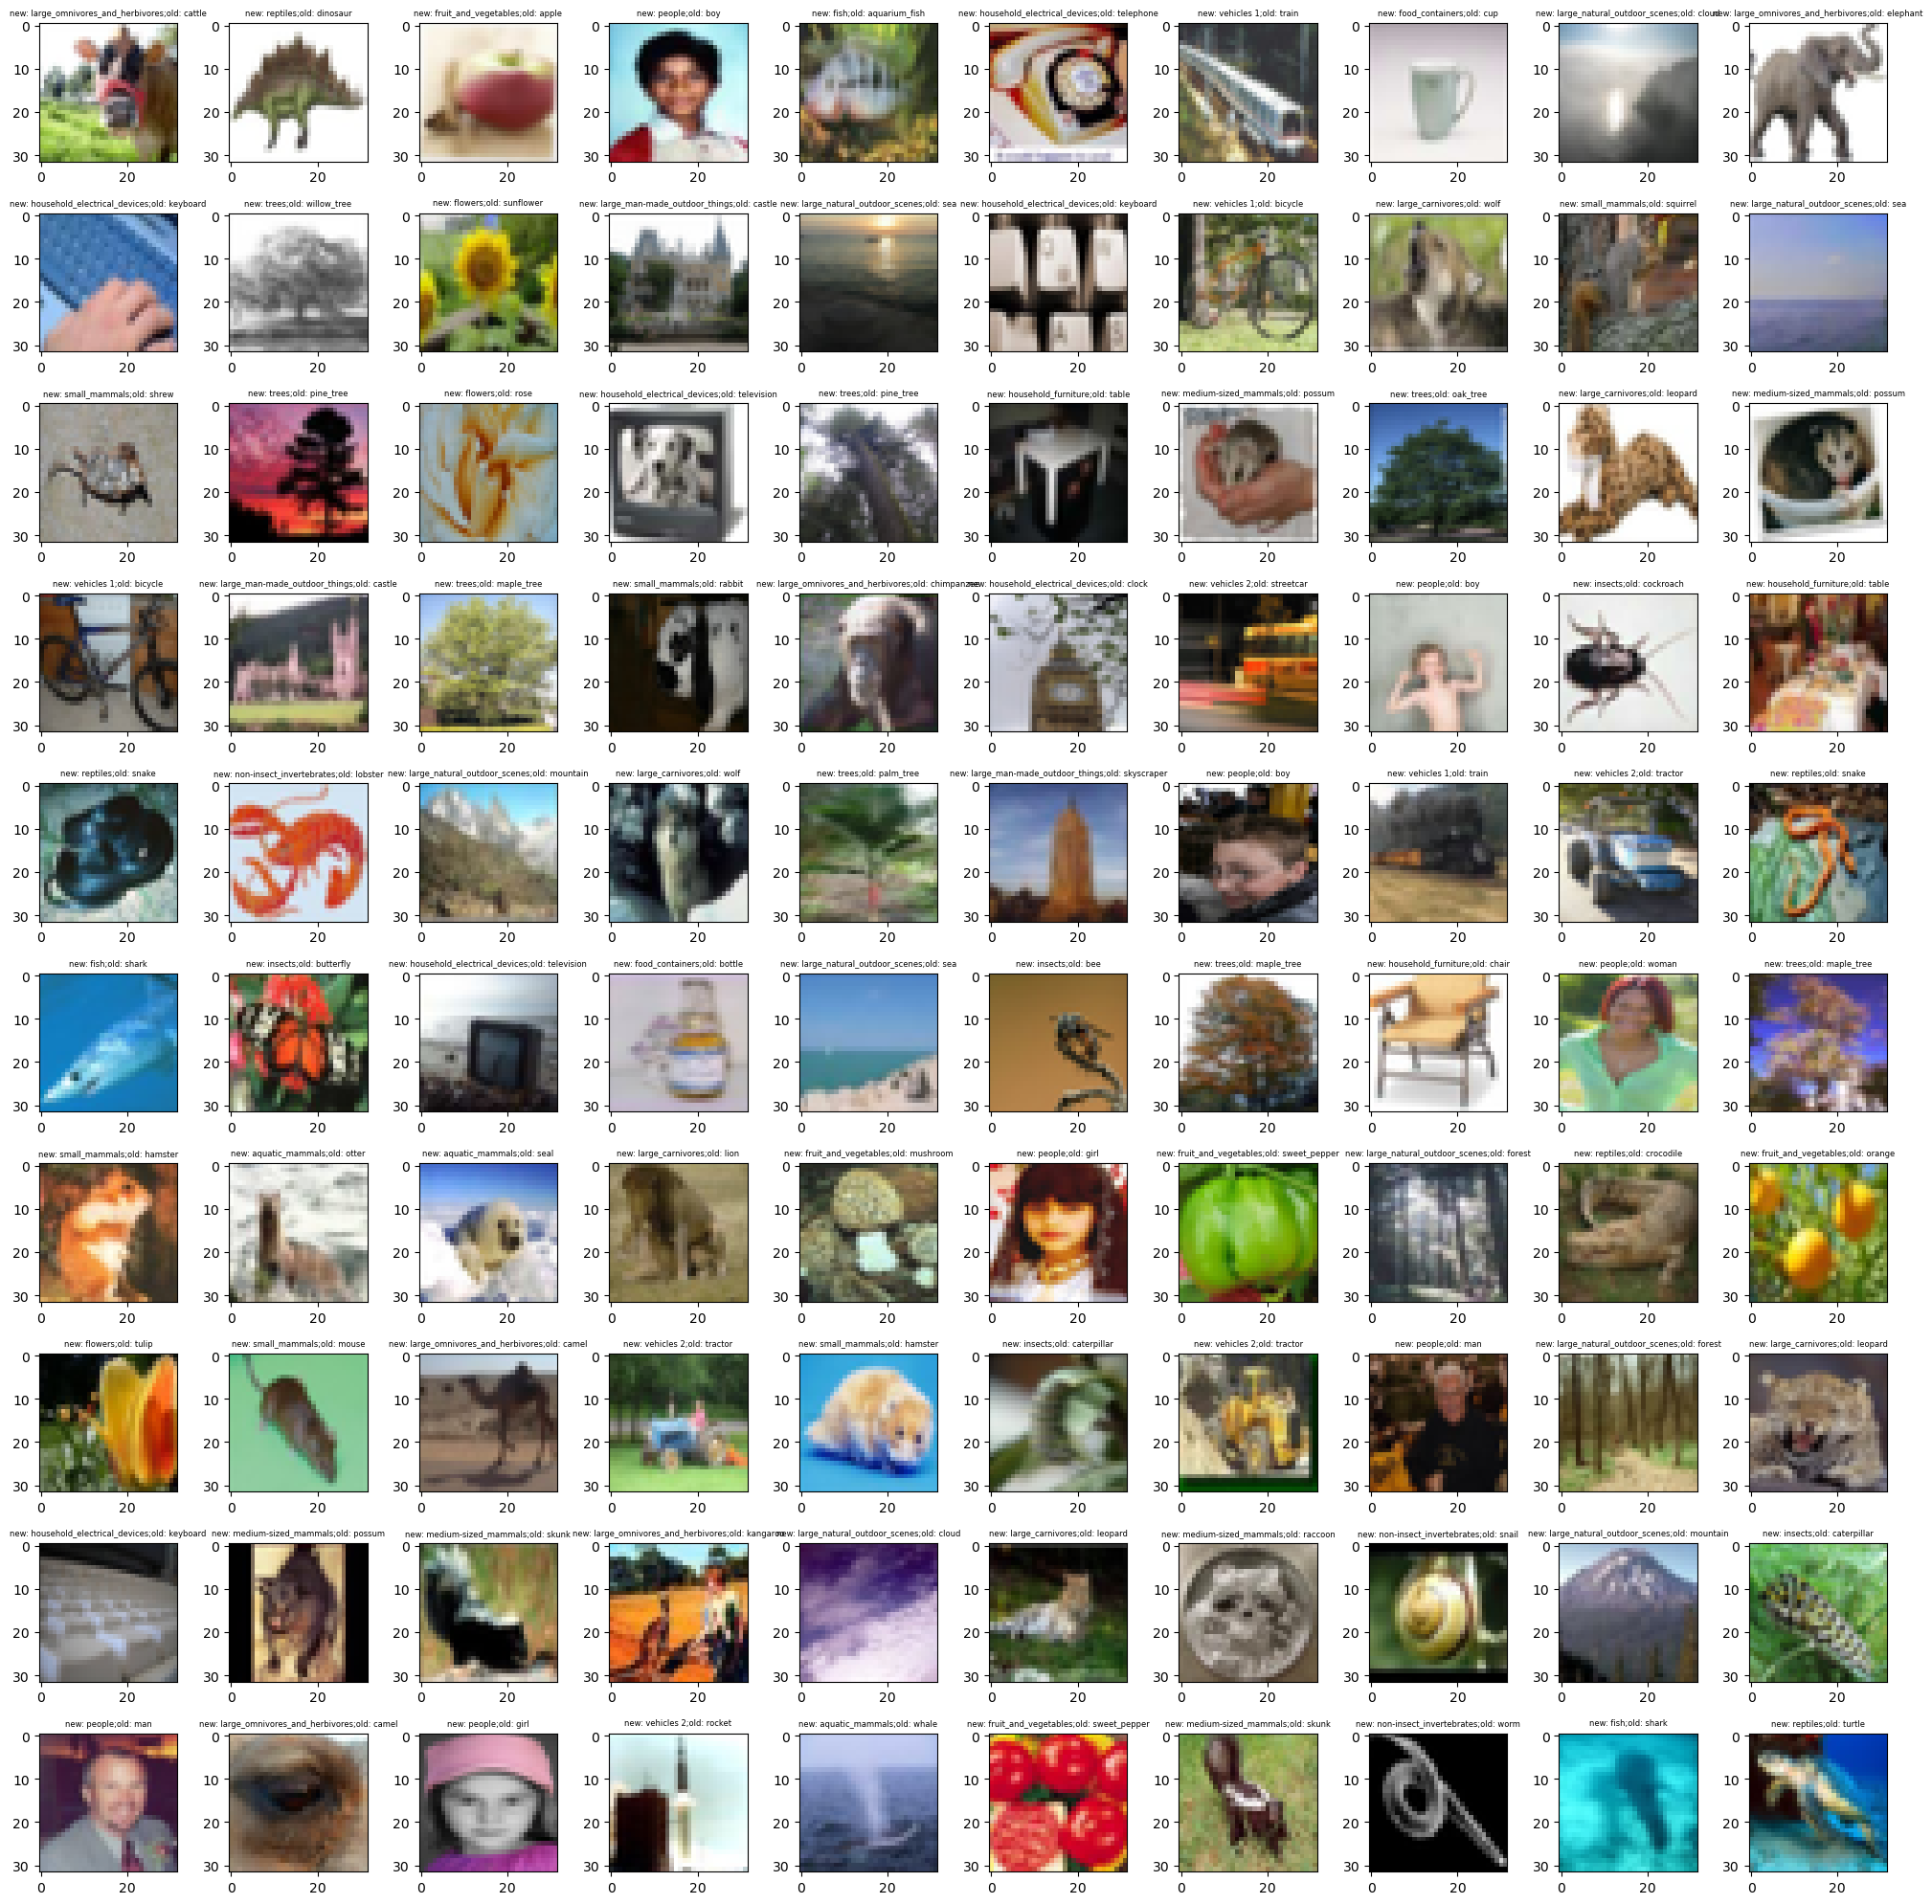

In [20]:
# Visualize Coarse Dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(10,10, figsize = (20,20))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(np.array(trainset[i*10 + j][0]))
        ax[i,j].set_title(f'new: {trainset_coarse.classes[trainset_coarse[i*10 + j][1]]};old: {trainset.classes[trainset[i*10 + j][1]]}',fontsize = 6)
plt.tight_layout()
plt.show()

In [7]:
# Prepare the Dataloaders

coarsetrain_loader = DataLoader(trainsplit_coarse, batch_size = 256, shuffle= True)
coarsevalid_loader = DataLoader(validsplit_coarse, batch_size = 256, shuffle= True)
coarsetest_loader = DataLoader(testset_coarse, batch_size = 256, shuffle= True)
finetrain_loader = DataLoader(trainsplit_fine, batch_size = 256, shuffle= True)
finevalid_loader = DataLoader(validsplit_fine, batch_size = 256, shuffle= True)
finetest_loader = DataLoader(testset, batch_size = 256, shuffle= True)

# Define the Predict Function
def predict(output):
    return torch.argmax(output, dim = 1)

# Define the Train Function
def train(model, train_dataloader, valid_dataloader, epochs, save_path, save_name, checkpoint_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Training on device: {device}')
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
    # optimizer = torch.optim.Adam(params= model.parameters(), lr = 0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min = 0)
    criterion = torch.nn.CrossEntropyLoss()
    best_loss = float('inf')
    start_epoch = 0
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint.get('best_loss', best_loss)
        print(f"Resumed training from epoch {start_epoch} with best validation loss {best_loss}")

    trloss_arr = []
    tracc_arr = []
    vldloss_arr = []
    vldacc_arr = []
    for epoch in range(start_epoch,epochs):
        model.train()
        train_loss = 0
        corrects = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            corrects += torch.sum(torch.eq(predict(outputs), labels))
            total += inputs.size(0)
        trloss_arr.append(train_loss / len(train_dataloader))
        tracc_arr.append(corrects / total)

        model.eval()
        valid_loss = 0
        corrects = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                corrects += torch.sum(torch.eq(predict(outputs),labels))
                total += inputs.size(0)
            vldloss_arr.append(valid_loss / len(valid_dataloader))
            vldacc_arr.append(corrects / total)
        print('Epoch: {ep}, TrainingLoss: {tl}, TrainingAccuracy: {ta}, ValidationLoss: {vl}, ValidationAccuracy: {va}'.format(ep = epoch, tl = trloss_arr[-1], ta = tracc_arr[-1], vl = vldloss_arr[-1], va = vldacc_arr[-1]))
        
        if vldloss_arr[-1] < best_loss:
            best_loss = vldloss_arr[-1]
            torch.save({'epoch': epoch + 1,
             'model_state_dict': model.state_dict(), 
             'optimizer_state_dict':optimizer.state_dict(), 
             'scheduler_state_dict':scheduler.state_dict(),
             'best_loss': best_loss},
                       f'{save_path}/{save_name}.pth')
            print('Best Loss: saving model...')

    return trloss_arr, tracc_arr, vldloss_arr, vldacc_arr

In [21]:
# Modify the Model Architecture to train on coarse labels
# torch.cuda.empty_cache()
# coarse_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet36", pretrained=False)
coarse_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
coarse_model.fc = torch.nn.Linear(coarse_model.fc.in_features, 20)
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(coarse_model, coarsetrain_loader, coarsevalid_loader, 200, '.', 'resnet20_coarse_real')

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Training on device: cuda
Epoch: 0, TrainingLoss: 2.500172337347811, TrainingAccuracy: 0.22031112015247345, ValidationLoss: 2.3064477920532225, ValidationAccuracy: 0.2849999964237213
Best Loss: saving model...
Epoch: 1, TrainingLoss: 2.108361216431314, TrainingAccuracy: 0.33791112899780273, ValidationLoss: 2.2036532878875734, ValidationAccuracy: 0.3245999813079834
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.8667326840487393, TrainingAccuracy: 0.40995556116104126, ValidationLoss: 2.056222552061081, ValidationAccuracy: 0.3893999755382538
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.67891806431792, TrainingAccuracy: 0.46542221307754517, ValidationLoss: 1.76251979470253, ValidationAccuracy: 0.43719998002052307
Best Loss: saving model...
Epoch: 4, TrainingLoss: 1.5491373694755814, TrainingAccuracy: 0.5035333633422852, ValidationLoss: 1.6509767949581147, ValidationAccuracy: 0.4797999858856201
Best Loss: saving model...
Epoch: 5, TrainingLoss: 1.4521445320411162, TrainingAccur

In [58]:
torch.cuda.empty_cache()
fine_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
fine_model.fc = torch.nn.Linear(coarse_model.fc.in_features, 100)
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(fine_model, finetrain_loader, finevalid_loader, 200, '.', 'resnet20_fine')

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Training on device: cuda
Epoch: 0, TrainingLoss: 2.425452920523557, TrainingAccuracy: 0.25086668133735657, ValidationLoss: 2.1979587078094482, ValidationAccuracy: 0.3093999922275543
Best Loss: saving model...
Epoch: 1, TrainingLoss: 1.9265049587596546, TrainingAccuracy: 0.3915555477142334, ValidationLoss: 1.9970342993736268, ValidationAccuracy: 0.3799999952316284
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.6550040753050284, TrainingAccuracy: 0.4712222218513489, ValidationLoss: 1.804657942056656, ValidationAccuracy: 0.4309999942779541
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.4589684781703083, TrainingAccuracy: 0.5331110954284668, ValidationLoss: 1.7275779008865357, ValidationAccuracy: 0.4529999792575836
Best Loss: saving model...
Epoch: 4, TrainingLoss: 1.3230796734040433, TrainingAccuracy: 0.5713333487510681, ValidationLoss: 1.5299953758716582, ValidationAccuracy: 0.5189999938011169
Best Loss: saving model...
Epoch: 5, TrainingLoss: 1.2181928090073846, TrainingAccu

([2.425452920523557,
  1.9265049587596546,
  1.6550040753050284,
  1.4589684781703083,
  1.3230796734040433,
  1.2181928090073846,
  1.1334539601071314,
  1.0688073174519972,
  1.0080675801092929,
  0.9564900323748589,
  0.9196664081378416,
  0.8799021982333877,
  0.8452326689254154,
  0.8079515936022456,
  0.7858997231180017,
  0.7532539746978066,
  0.7348016290502115,
  0.7122712665322152,
  0.6838194309649143,
  0.6685212623666633,
  0.6586238948458975,
  0.6361003101549365,
  0.6241168544035066,
  0.607518411156806,
  0.5993669563057747,
  0.5830655014989051,
  0.5737294217740948,
  0.5638228729367256,
  0.5506534456190738,
  0.5519423384896733,
  0.5339544259689071,
  0.5246532953936945,
  0.5100700724869967,
  0.5262558253651316,
  0.5058946931226687,
  0.5021081404252485,
  0.49111500331623986,
  0.49000582251359115,
  0.4856489920480685,
  0.4808296254751357,
  0.4860052681443366,
  0.4674715587699955,
  0.47294086624275555,
  0.4761703017760407,
  0.4446458752182397,
  0.47607

In [8]:
# Train
aqua_animal_train_idx = [i for i in trainsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 0]
aqua_animal_valid_idx = [i for i in validsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 0]
fish_train_idx = [i for i in trainsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 1]
fish_valid_idx = [i for i in validsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 1]
aqua_dataset = TransformedSubset(trainset, aqua_animal_train_idx, augmentation_transform)
aqua_valid_dataset =TransformedSubset(trainset, aqua_animal_valid_idx, transform)
fish_dataset = TransformedSubset(trainset, fish_train_idx, augmentation_transform)
fish_valid_dataset =TransformedSubset(trainset, fish_valid_idx, transform)
aqua_trainloader = DataLoader(aqua_dataset, batch_size = 32, shuffle = True)
fish_trainloader = DataLoader(fish_dataset, batch_size = 32, shuffle = True)
aqua_validloader = DataLoader(aqua_valid_dataset, batch_size = 32)
fish_validloader = DataLoader(fish_valid_dataset, batch_size = 32)
# Test
aqua_animal_test_idx = [i for i in range(len(testset)) if sparse2coarse(testset.targets[i]) == 0]
aqua_testset = TransformedSubset(testset, aqua_animal_test_idx, transform)
aqua_testloader = DataLoader(aqua_testset, batch_size = 32)
fish_animal_test_idx = [i for i in range(len(testset)) if sparse2coarse(testset.targets[i]) == 1]
fish_testset = TransformedSubset(testset, fish_animal_test_idx, transform)
fish_testloader = DataLoader(fish_testset, batch_size = 32)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
base_model.fc = torch.nn.Linear(base_model.fc.in_features, 20)
checkpoint = torch.load('resnet20_coarse_real.pth', map_location=device)
base_model.load_state_dict(checkpoint['model_state_dict'])
base_model.fc = torch.nn.Linear(base_model.fc.in_features, 100)


Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [34]:
# finetune for each model
a,b,c,d = train(deepcopy(base_model), aqua_trainloader, aqua_validloader ,20,'.','aquatic_resnet20',None)
a,b,c,d = train(deepcopy(base_model), fish_trainloader, fish_validloader ,20,'.','fish_resnet20',None)

Training on device: cuda
Epoch: 0, TrainingLoss: 1.3760848624838724, TrainingAccuracy: 0.4550241231918335, ValidationLoss: 1.7972502538136073, ValidationAccuracy: 0.3710407316684723
Best Loss: saving model...
Epoch: 1, TrainingLoss: 1.1203332650992606, TrainingAccuracy: 0.5133830308914185, ValidationLoss: 1.3994393859590804, ValidationAccuracy: 0.4117647111415863
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.0757584331764116, TrainingAccuracy: 0.5392715930938721, ValidationLoss: 1.3491632086890084, ValidationAccuracy: 0.4751131534576416
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.0027580112218857, TrainingAccuracy: 0.5603334903717041, ValidationLoss: 1.2777282510484969, ValidationAccuracy: 0.5067873597145081
Best Loss: saving model...
Epoch: 4, TrainingLoss: 0.9619619126121203, TrainingAccuracy: 0.5919262766838074, ValidationLoss: 1.1998826605933053, ValidationAccuracy: 0.5067873597145081
Best Loss: saving model...
Epoch: 5, TrainingLoss: 0.9460216412941614, TrainingAcc

In [9]:
def test(model, test_dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    model.eval()
    
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0
    corrects = 0
    total = 0
    
    with torch.no_grad():
#         print(test_dataloader)
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device).long()
#             print("Labels:", labels)  # Debug statement
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            corrects += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = corrects / total
    
    print(f'Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}')
    return avg_test_loss, test_accuracy

In [ ]:
# Test Accuracy to coarse model, fine_tuned models

In [11]:
# Use the test function
aquatic_model = torch.load('aquatic_resnet20.pth', map_location='cuda')
aquatic = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
aquatic.load_state_dict(aquatic_model['model_state_dict'])
aqua_loss, aqua_acc = test(aquatic, aqua_testloader)
fish_model = torch.load('fish_resnet20.pth', map_location='cuda')
fish = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
fish.load_state_dict(fish_model['model_state_dict'])
aqua_loss, aqua_acc = test(fish, fish_testloader)
# finetest_loss, finetest_accuracy = test(fine_model, finetest_loader)

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Test Loss: 1.0391607619822025, Test Accuracy: 0.582


Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Test Loss: 0.8241297174245119, Test Accuracy: 0.734


In [12]:
# Get model parameters

import torch.nn as nn
from scipy.optimize import linear_sum_assignment


# # Function to extract filters from convolutional layers
# def extract_conv2d_layers(model, layers=None):
#     if layers is None:
#         layers = []

#     # Recursively traverse the children of the model
#     for layer in model.children():
#         if isinstance(layer, nn.Conv2d):
#             layers.append(layer)
#         else:
#             # If the current layer itself is not a Conv2d but might have children
#             # that are, recursively search its children
#             extract_conv2d_layers(layer, layers)

    # return layers
# def extract_conv_layers(model):
#     layers = []
#     for name, module in model.named_modules():
#         if isinstance(module, nn.Conv2d):
#             layers.append((name, module))
#     return layers
# # Function to Extract all the filters from the model

# Extract all conv2d layers from the model
def extract_conv_layers(model):
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            layers.append((name, module))
    return layers





In [38]:
class MergedModel(nn.Module):
    def __init__(self, model1, model2):
        super(MergedModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.partial_merge_model1 = deepcopy(model1)
        self.partial_merge_model2 = deepcopy(model2)
        self.merged_layers = []

    def forward(self, x):
        x1 = self.partial_merge_model1(x)
        x2 = self.partial_merge_model2(x)
        return x1, x2
    
    # get first n conv2d layers of a given model
    def get_first_n_conv2d_layers(self, model, n):
        layers = []
        for name, module in model.named_modules():
            if isinstance(module, nn.Conv2d):
                layers.append((name, module))
                if len(layers) == n:
                    break
        return layers
    
    # calculate the L1 distance matrix between two conv2d layers
    def calculate_l1_distance_matrix(self, layer1, layer2):
        # get the weights of the two layers
        weights1 = layer1.weight.data
        weights2 = layer2.weight.data
        
        # calculate the L1 distance matrix
        l1_distance_matrix = torch.zeros(weights1.size(0), weights2.size(0))
        for i in range(weights1.size(0)):
            for j in range(weights2.size(0)):
                l1_distance_matrix[i, j] = torch.norm(weights1[i] - weights2[j], p=1)
        
        return l1_distance_matrix
    
    # get the indices of the filters that are most similar between two conv2d layers
    def get_most_similar_filters(self, layer1, layer2):
        # calculate the L1 distance matrix
        l1_distance_matrix = self.calculate_l1_distance_matrix(layer1, layer2)
        
        # apply the Hungarian algorithm to find the optimal filter indices
        row_indices, col_indices = linear_sum_assignment(l1_distance_matrix)
        
        return row_indices, col_indices
    
    # merge the filters of two conv2d layers
    def merge_filters(self, layer1, layer2, row_indices, col_indices):
        # get the weights of the two layers
        weights1 = layer1.weight.data
        weights2 = layer2.weight.data
        
        # merge the filters
        merged_weights = (weights1[row_indices] + weights2[col_indices]) / 2
        
        return merged_weights
    
    # merge the first n pairs of conv2d layers in model1 and model2, replace the first n conv2d layers in partial_merge_model1 and partial_merge_model2 with the merged filters
    def merge_layers(self, n):
        # get the first n conv2d layers of model1 and model2
        model1_layers = self.get_first_n_conv2d_layers(self.model1, n)
        model2_layers = self.get_first_n_conv2d_layers(self.model2, n)
        
        # merge the filters of the first n pairs of conv2d layers
        for i in range(n):
            layer1 = model1_layers[i][1]
            layer2 = model2_layers[i][1]
            row_indices, col_indices = self.get_most_similar_filters(layer1, layer2)
            merged_weights = self.merge_filters(layer1, layer2, row_indices, col_indices)
            self.partial_merge_model1.state_dict()[model1_layers[i][0] + '.weight'].copy_(merged_weights)
            self.partial_merge_model2.state_dict()[model2_layers[i][0] + '.weight'].copy_(merged_weights)
            self.merged_layers.append((model1_layers[i][0], model2_layers[i][0], row_indices, col_indices))



In [39]:
# reload the aquatic and fish models
aquatic_model = torch.load('aquatic_resnet20.pth', map_location='cuda')
aquatic = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
aquatic.load_state_dict(aquatic_model['model_state_dict'])
fish_model = torch.load('fish_resnet20.pth', map_location='cuda')
fish = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
fish.load_state_dict(fish_model['model_state_dict'])
# evaluate the aquatic and fish models on dataset aqua and fish
aqua_loss, aqua_acc = test(aquatic, aqua_testloader)
fish_loss, fish_acc = test(fish, fish_testloader)

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Test Loss: 1.0391607619822025, Test Accuracy: 0.582
Test Loss: 0.8241297174245119, Test Accuracy: 0.734


In [41]:
# Initialize the merged model with model aqua and fish
merged_model = MergedModel(aquatic, fish)
# Merge the first 5 pairs of conv2d layers
merged_model.merge_layers(2)
# Test the two partial merge models on dataset aqua and fish respectively
aqua_loss, aqua_acc = test(merged_model.partial_merge_model1, aqua_testloader)
fish_loss, fish_acc = test(merged_model.partial_merge_model2, fish_testloader)

Test Loss: 1.0216684974730015, Test Accuracy: 0.584
Test Loss: 0.876642232760787, Test Accuracy: 0.71


Test Loss: 1.0391607619822025, Test Accuracy: 0.582
Test Loss: 0.8241297174245119, Test Accuracy: 0.734
Test Loss: 1.025115106254816, Test Accuracy: 0.57
Test Loss: 0.8099851571023464, Test Accuracy: 0.738
Test Loss: 1.0216684974730015, Test Accuracy: 0.584
Test Loss: 0.876642232760787, Test Accuracy: 0.71
Test Loss: 1.0186359398066998, Test Accuracy: 0.58
Test Loss: 0.9263871498405933, Test Accuracy: 0.704
Test Loss: 1.0246646404266357, Test Accuracy: 0.582
Test Loss: 0.9375411681830883, Test Accuracy: 0.696
Test Loss: 1.0715386942029, Test Accuracy: 0.552
Test Loss: 1.0283776186406612, Test Accuracy: 0.664
Test Loss: 1.0951941572129726, Test Accuracy: 0.554
Test Loss: 1.0375527944415808, Test Accuracy: 0.664
Test Loss: 1.0818815119564533, Test Accuracy: 0.558
Test Loss: 1.0490274969488382, Test Accuracy: 0.652
Test Loss: 1.149935357272625, Test Accuracy: 0.548
Test Loss: 1.3093318305909634, Test Accuracy: 0.588
Test Loss: 1.0820658169686794, Test Accuracy: 0.546
Test Loss: 1.56296961

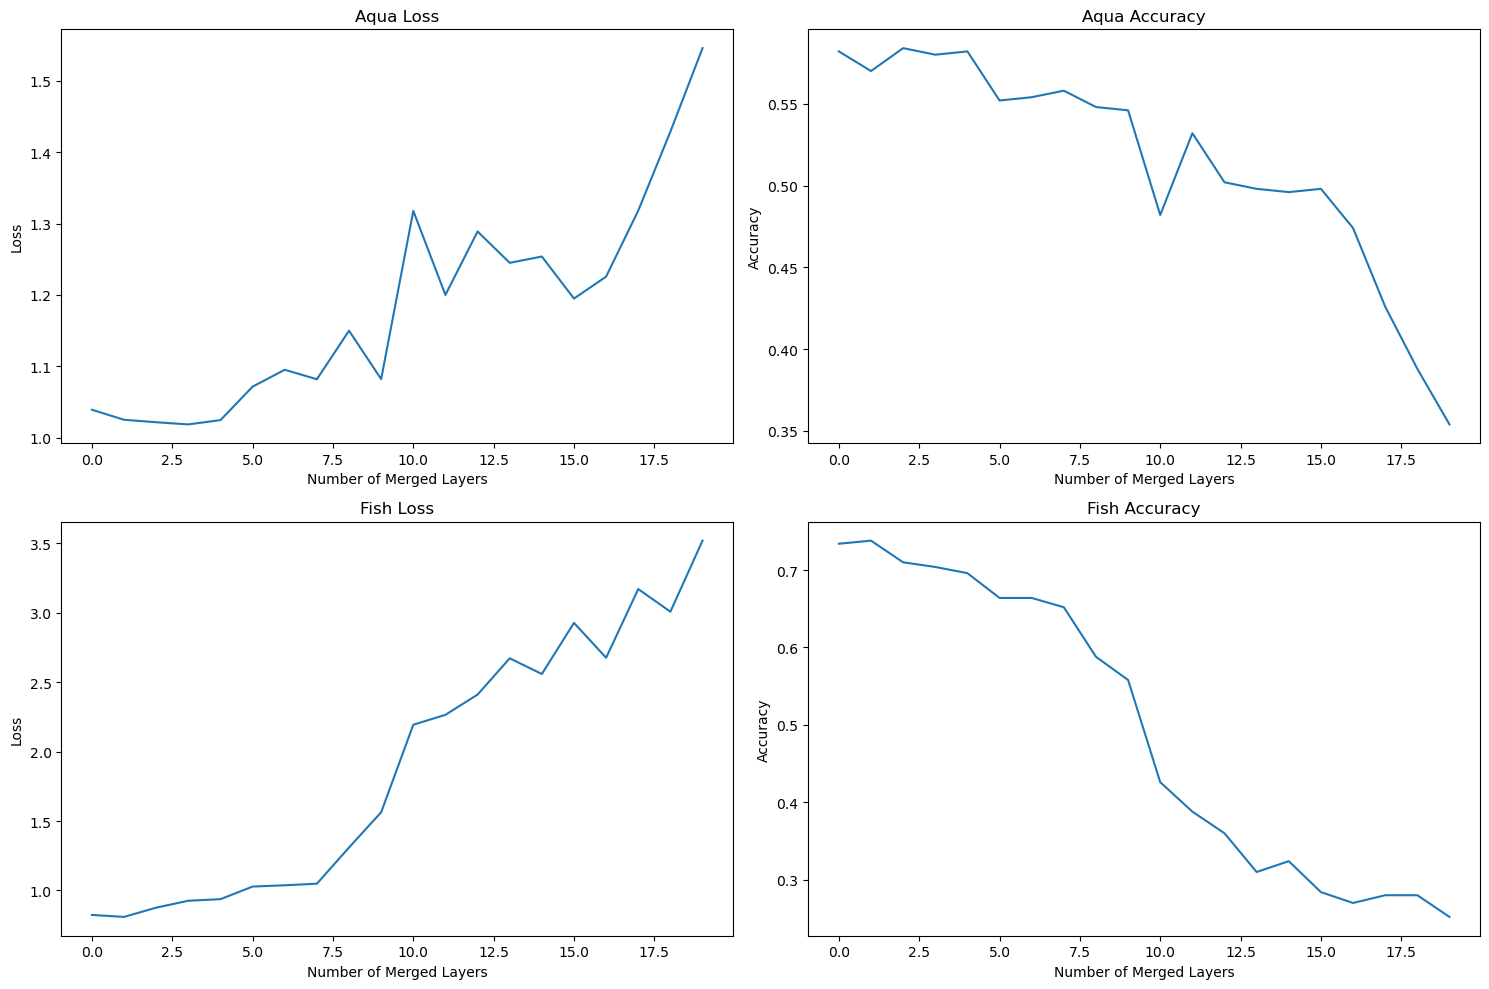

In [44]:
import matplotlib.pyplot as plt
# Reinitialize the merged model with model fish and aqua
merged_model = MergedModel(aquatic, fish)
# Merge all the conv2d layers one by one and evaluate the two partial merge models on dataset aqua and fish respectively
# add loss and accuracy list for aqua and fish
aqua_loss_list = []
aqua_acc_list = []
fish_loss_list = []
fish_acc_list = []
for i in range(20):
    merged_model.merge_layers(i)
    aqua_loss, aqua_acc = test(merged_model.partial_merge_model1, aqua_testloader)
    fish_loss, fish_acc = test(merged_model.partial_merge_model2, fish_testloader)
    # append loss and accuracy to the list
    aqua_loss_list.append(aqua_loss)
    aqua_acc_list.append(aqua_acc)
    fish_loss_list.append(fish_loss)
    fish_acc_list.append(fish_acc)
# plot the loss and accuracy of the two partial merge models on dataset aqua and fish respectively
# make it a 2x2 plot with x-axis as the number of merged layers and y-axis as the loss or accuracy
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(range(20), aqua_loss_list)
axs[0, 0].set_title('Aqua Loss')
axs[0, 0].set_xlabel('Number of Merged Layers')
axs[0, 0].set_ylabel('Loss')
axs[0, 1].plot(range(20), aqua_acc_list)
axs[0, 1].set_title('Aqua Accuracy')
axs[0, 1].set_xlabel('Number of Merged Layers')
axs[0, 1].set_ylabel('Accuracy')
axs[1, 0].plot(range(20), fish_loss_list)
axs[1, 0].set_title('Fish Loss')
axs[1, 0].set_xlabel('Number of Merged Layers')
axs[1, 0].set_ylabel('Loss')
axs[1, 1].plot(range(20), fish_acc_list)
axs[1, 1].set_title('Fish Accuracy')
axs[1, 1].set_xlabel('Number of Merged Layers')
axs[1, 1].set_ylabel('Accuracy')
plt.tight_layout()
plt.show()
